In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from multiprocessing import Pool # waning: it will raise exception if executed in notebook
from nltk.corpus import stopwords

In [2]:
from tqdm.notebook import tqdm

In [3]:
from IPython.display import display, HTML

In [4]:
sw = stopwords.words('english')

# Text from sentences
Example of sentences are taken from `20 newsgroup`

In [5]:
import nltk
from sklearn.datasets import fetch_20newsgroups

In [6]:
train = fetch_20newsgroups(data_home="/Users/flint/Data/sklearn/", subset='train', 
                           remove=('headers', 'footers', 'quotes'),
                           categories=['rec.sport.baseball'])

In [12]:
print(train.data[2])
print(train.target_names)


I have lived in the Boston area for 15 years now.  They have been talking
about a new Boston Garden (hockey/basketball) since I've lived here.  One
day the "last hurdle" has been overcome, and the next day there's a new
hurdle.  Fans have been grumbling about Foxboro Stadium (or whatever it's
called this year) for nearly as long, but there are only preliminary
proposals for a new stadium.  Local politics prevents anything from being
done in a timely fashion.  There will not be a new ballpark in my
lifetime.
['rec.sport.baseball']


In [13]:
sentences = []
for doc in train.data:
    for s in nltk.tokenize.sent_tokenize(doc):
        sentences.append(s.lower())

In [15]:
print(sentences[1])


so you want to decrease players' salaries?


# One-hot encoding
Many current NLP systems and techniques treat words as atomic
units - there is no notion of similarity between words, as these are
represented as indices in a vocabulary <br/>
<i>(Mikolov et al., 2013).</i>

<br/>
Suppose that the number of different words in the vocabulary (the vocabulary size) is $V$. To obtain the one-hot vector representation for any word with index $i$, we create a length-$V$ vector with all $0$s and set the element at position $i$ to $1$

In [16]:
from nltk.tokenize import word_tokenize

In [17]:
corpus = sentences
V = set()
for sentence in corpus:
    for word in word_tokenize(sentence):
        V.add(word)
V = list(V)

In [18]:
# example
print('Vocab size:', len(V))

Vocab size: 8723


In [19]:
V.index('suppose')

7354

In [20]:
def one_hot_encoding(V, word) -> np.array:
    """Return one-hot encoding
    
    Args:
        V(list): Vocabulary, i.e., word list.
        word: word in the vocabulary.
    Returns:
        one_hot_encoding(np.array)
    """
    vec = np.zeros(len(V))
    vec[V.index(word)] = 1.0
    return vec

In [21]:
# example
word1, word2 = V[1], V[2]
vec1, vec2 = one_hot_encoding(V, word1), one_hot_encoding(V, word2)

print(f"One-hot Encoding: {word1}:", vec1)
print(f"One-hot Encoding: {word2}:", vec2)

One-hot Encoding: next: [0. 1. 0. ... 0. 0. 0.]
One-hot Encoding: still: [0. 0. 1. ... 0. 0. 0.]


One-hot encoded vectors are orthonormal. <br/>

For vectors $x, y \in \mathbb{R}^V$ with $x\ne y$, their _similarity_ is always $0$. 

On the contrary, for vectors $x, y \in \mathbb{R}^V$ with $x = y$, their _similarity_ is always $1$.

\begin{equation*}
\frac{x^T \ y}{\|x\| \ \|y\|} \in \{0, 1\}
\end{equation*}

In [22]:
def cosine_similarity(vec1: np.array, vec2: np.array) -> float:
    """Return cosine similarity between two vectors
    
    Args:
        vec1(np.array): vector 1.
        vec2(np.array): vector 2.
    Returns:
        cosine similarity
    """
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [23]:
# example 
example_words = [V[i] for i in range(10)]
vectors = [one_hot_encoding(V, w) for w in example_words]
sigma = dict([(w, {}) for w in example_words])
for i, w1 in enumerate(example_words):
    for j, w2 in enumerate(example_words):
        sigma[w1][w2] = cosine_similarity(vectors[i], vectors[j])
pd.DataFrame(sigma)

,wiped,next,still,power,0.295,again,fox,mound,bodies,yankovic
wiped,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
next,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
still,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
power,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0.295,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
again,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
fox,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
mound,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
bodies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
yankovic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
v_play = one_hot_encoding(V, 'play')
v_game = one_hot_encoding(V, 'game')

In [25]:
cosine_similarity(v_play, v_game)

0.0

# Word2Vec: semantic word representations

Word2Vec maps each word to a **low-dimensional continuous vector**, in a way that words that have similar meaning have similar representations.
	
Word2Vec is based on a simple but efficient *feed-forward* neural architecture which is trained with language modeling objective. 

Word2Vec consists of two different architectures: __Skip-gram__ and __Continuous Bag-of-Words__ (CBOW).

## Generating variables

In [26]:
import string

In [27]:
tokens = [[x for x in word_tokenize(t) if x not in sw and x not in string.punctuation] for t in corpus]

In [28]:
# example
print(corpus[20], end='\n\n')
print(tokens[20])

finally, i throw all this into a a formula i call defensive contribution, or
dcon :->.

['finally', 'throw', 'formula', 'call', 'defensive', 'contribution', 'dcon']


In [29]:
def build_vocab(token_batches, min_count=15) -> dict:
    '''Build vocabulary and filter rare words.
    
    Args:
        token_batches(list): Token batches.
        min_count(int, optional, default=15): Minimum frequency threshold.
    Returns:
        vocab(dict): Dictionary containing token and frequencies.
    '''
    
    counts = Counter([token for tokens in token_batches for token in tokens])
    vocab = list(counts.keys())
    vocab = {k:v for k, v in counts.items() if v > min_count} # Filtering
    return vocab

vocab = build_vocab(tokens, min_count=10)
vocab_size = len(vocab)

In [30]:
# example
print(vocab_size, '\n')
print(f"  ..., {str({k: vocab[k] for k in sorted(vocab)[100:107]})[1:-1]},  ...".replace(',', ',\n'))

824 

  ...,
 '7': 76,
 '70': 12,
 '8': 36,
 '80': 14,
 '89': 11,
 '9': 47,
 '92': 12,
  ...


In [31]:
def mapping(vocab: list) -> tuple:
    '''
    Generate mapping dictionaries.
    
    Args:
        vocab(dict): Dictionary containing token and frequencies.
    Returns:
        token_to_id(dict): Mapping token -> id. 
        id_to_token(dict): Mapping id -> token. 
    '''
    token_to_id = dict()
    id_to_token = dict()

    for i, token in enumerate(vocab):
        token_to_id[token] = i
        id_to_token[i] = token

    return token_to_id, id_to_token

token_to_id, id_to_token = mapping(vocab)

In [32]:
# example
print(token_to_id['pitch'],':', id_to_token[token_to_id['pitch']])

345 : pitch


## Generating training samples

In [33]:
def one_hot_encoding(token_id, vocab_size) -> np.array:
    '''Return one-hot encoding
    
    Args:
        token_id(int): Token id.
        vocab_size(int): Number of token in the dictionary.
    Returns:
        one_hot_encoding(np.array)
    '''
    vec = np.zeros(vocab_size)
    vec[token_id] = 1.0
    return vec

In [35]:
def generate_training_samples(tokens: list, token_to_id: dict, id_to_token: dict, window:int=3) -> list:
    '''Generate training examples for word2vec algorithm.
    
    Args:
        tokens(list): Batch of tokens.
        token_to_id(dict): Mapping token -> id.
        id_to_token(dict): Mapping id -> token.
        window(int, optional, default=5): Number of left and right context words for each target word.
    
    Returns:
        examples(list).
    '''
    
    examples = list()
    n_tokens = len(tokens)

    for i in range(n_tokens):
        if tokens[i] not in token_to_id: continue
            
        target = token_to_id[tokens[i]]
        new_examples = list()

        for j in range(1, window+2):
            # right context
            if i + j < len(tokens):
                if not tokens[i + j] in token_to_id: continue
                context = token_to_id[tokens[i + j]]
                new_examples.append((target, context))
                
            # left context
            if i - j >= 0:
                if not tokens[i - j] in token_to_id: continue
                context = token_to_id[tokens[i - j]]
                new_examples.append((target, context))
            
        examples.append(new_examples)

    return np.asarray(examples, dtype=object)

def generate_multiple_training_samples(token_batches: list, token_to_id: dict, id_to_token: dict, window:int=3, 
                                   workers:int = 10):
    '''Generate training example for word2vec algorithm.
    
    Args:
        tokens(list): Batch of tokens.
        token_to_id(dict): Mapping token -> id.
        id_to_token(dict): Mapping id -> token.
        vocab_size(int): Number of token in the dictionary.
        window(int, optional, default=5): Number of left and right context words for each target word.'''
    
    
    with Pool(processes=workers) as p:
         res = p.starmap(generate_training_samples, [(tokens, token_to_id, id_to_token, window) for tokens in token_batches])
    
    return res

window = 3
#samples = generate_multiple_training_samples(tokens, token_to_id, id_to_token, window=3, workers=10) # not working in notebook
samples = [generate_training_samples(t, token_to_id, id_to_token, window=window) for t in tokens]

In [38]:
print(tokens[20])
for e in generate_training_samples(tokens[20], token_to_id, id_to_token):
    print([(id_to_token[a], id_to_token[b]) for a, b in e])

['finally', 'throw', 'formula', 'call', 'defensive', 'contribution', 'dcon']
[('finally', 'throw'), ('finally', 'call'), ('finally', 'defensive')]
[('throw', 'call'), ('throw', 'defensive')]
[('call', 'defensive')]
[('defensive', 'throw'), ('defensive', 'finally')]


In [39]:
def color(text, color='#990000'):
    return "<span style='color: {};'>{}</span>".format(color, text)

In [40]:
example = 20

print(" ".join(tokens[example]), end='\n')

for i in range(len(tokens[example])):
    if i>5: break
    before = " ".join([t for j, t in enumerate(tokens[example]) if j < i-window])
    context_l = color(" ".join(tokens[example][max(i-window,0):i]), '#000099')
    target = color(tokens[example][i], '#990000')
    context_r = color(" ".join(tokens[example][i+1:i+window+1]), '#000099')
    after = " ".join(tokens[example][i+window+1:])
    html = '{}. '.format(i) + " " + before + " " + context_l + " " + target + " " + context_r + " " + after
    display(HTML(html))

training_samples = generate_training_samples(tokens[example], token_to_id, id_to_token, window)[0]

print('Training Example (id, id) - 4:')
print(str(training_samples), '\n\n')

print('Training Example (word, word) - 4:')
print(str(np.array([[id_to_token[i[0]], id_to_token[i[1]]] for i in training_samples])), '\n\n')

print('Training Example (id, id) - 4:')
print(str(np.array([[one_hot_encoding(i[0], vocab_size), 
                     one_hot_encoding(i[1], vocab_size)] 
                    for i in training_samples])))

finally throw formula call defensive contribution dcon


Training Example (id, id) - 4:
[(71, 72), (71, 73), (71, 45)] 


Training Example (word, word) - 4:
[['finally' 'throw']
 ['finally' 'call']
 ['finally' 'defensive']] 


Training Example (id, id) - 4:
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


# CBOW

## Word2Vec: CBOW

_input to hidden_ 

Input layer: $\mathbf{x} \in \mathbb{R}^{V}$ <br/>
 \begin{eqnarray*}
	        \bar{\mathbf{x}} = \frac{1}{C}\sum^C_{c=1} \mathbf{x^{(c)}}
	    \end{eqnarray*}
Weights: $W \in \mathbb{R}^{V\times N}$, randomly initialized<br/><br/>
Hidden layer: $\mathbf{h} \in \mathbb{R}^{N}$
\begin{eqnarray}
\mathbf{h} = \frac{1}{C} \mathbf{W}^T \sum^C_{c=1}  x^{(c)} = \mathbf{W}^T \bar{\mathbf{x}}
\end{eqnarray}

Activation function: $\mathbb{I}\text{dentity}$

_hidden to output_

Weights: $\mathbf{W'} \in \mathbb{R}^{N\times V}$, randomly initialized

Output layer: $\mathbf{u} \in \mathbb{R}^V$
\begin{eqnarray}
\mathbf{u} = \mathbf{W}'^T \mathbf{h} = \frac{1}{C} \sum^C_{c=1} \mathbf{W'}^T \mathbf{W}^T x^{(c)} = \mathbf{W'}^T \mathbf{W}^T \bar{\mathbf{x}}
\end{eqnarray}

Activation function: $\mathbb{S}\text{oftmax}$
\begin{eqnarray}
\mathbf{y} = \mathbb{S}\text{oftmax}(\mathbf{u}) = \mathbb{S}\text{oftmax}(\mathbf{W'}^T\mathbf{W}^T \bar{\mathbf{x}})
\end{eqnarray}

_Loss Function_

\begin{eqnarray}
\mathcal{L} &=& -\log \mathbb{P}(w_O| w_{c,1}, w_{c,2}, ..., w_{c,C})\\
&=& \max \log y_{j^*} \nonumber\\
		            &=& \max \log \left(\frac{\exp(u_{j^*})}{\sum^V_{j'=1} \exp(u_{j'})} \right) \nonumber\\
		            &=& \max u_{j^*} - \log \sum^V_{j' = 1} \exp(u_{j'}) \nonumber\\
		            &=& \min \log \sum^V_{j' = 1} \exp(u_{j'}) - u_{j^*}
\end{eqnarray}

_Gradient descent_

\begin{eqnarray}
	    \frac{\partial \mathcal{L}}{\partial \mathbf{W'}} = (\mathbf{W}^T \bar{\mathbf{x}}) \otimes E 
	    \end{eqnarray}
	    \begin{eqnarray} \frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \bar{\mathbf{x}} \otimes (\mathbf{W'} E) 
	    \end{eqnarray}
        
_Backpropagation_
\begin{eqnarray}
\mathbf{v}_{W}^{(new)} &=&  \mathbf{v}_{W}^{(old)} - \eta \cdot \frac{\partial \mathcal{L}}{\partial W}
\end{eqnarray}
                
\begin{eqnarray}
    \mathbf{v}_{W'}^{(new)} &=&  \mathbf{v}_{W'}^{(old)} - \eta \cdot \frac{\partial \mathcal{L}}{\partial W'}
\end{eqnarray}

In [41]:
def softmax(x):
    x = x.astype(float)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [42]:
class Word2Vec:
    
    def __init__(self, sequences:list, vector_size=100):
        """
        Args:
            sequences(list): Token batches.
        """
        self.sequences = sequences
        self.vector_size = vector_size
    
    def __init_network__(self):
        """Initialize the network"""
        
        self.model = {
            "W": np.random.uniform(-1, 1, (self.vocab_size, self.vector_size)),  # input to hidden
            "W'": np.random.uniform(-1, 1, (self.vector_size, self.vocab_size)) # hidden to output
        }
        return self.model
    
    def build_vocab(self, min_count=15) -> dict:
        """Build vocabulary and filter rare words.

        Args:
            min_count(int, optional, default=15): Minimum frequency threshold.
        Returns:
            vocab(dict): Dictionary containing token and frequencies.
        """

        counts = Counter([token for sequence in self.sequences for token in sequence])
        vocab = list(counts.keys())
        vocab = {k:v for k, v in counts.items() if v > min_count} # Filtering

        self.vocab = vocab
        self.vocab_size = len(vocab)
        
        self.token_to_id, self.id_to_token = self.__mapping__()
        
        return vocab
    
    def one_hot_encoding(self, token_id) -> np.array:
        '''Return one-hot encoding

        Args:
            token_id(int): Token id.
        Returns:
            one_hot_encoding(np.array)
        '''
        vec = np.zeros(self.vocab_size)
        vec[token_id] = 1.0
        return vec
    
    def __mapping__(self) -> tuple:
        '''
        Generate mapping dictionaries.

        Returns:
            token_to_id(dict): Mapping token -> id. 
            id_to_token(dict): Mapping id -> token. 
        '''
        token_to_id = dict()
        id_to_token = dict()

        for i, token in enumerate(self.vocab):
            token_to_id[token] = i
            id_to_token[i] = token
        
        return token_to_id, id_to_token

    def __generate_training_samples__(self, tokens: list, window:int=3) -> list:
        '''Generate training examples for word2vec algorithm.

        Args:
            tokens(list): Batch of tokens.
            window(int, optional, default=3): Number of left and right context words for each target word.

        Returns:
            examples(list).
        '''

        examples = list()
        n_tokens = len(tokens)

        for i in range(n_tokens):
            if tokens[i] not in self.token_to_id: continue

            target = self.token_to_id[tokens[i]]
            X, y = list(), np.array(self.one_hot_encoding(target))

            for j in range(1, window+2):
                # right context
                if i + j < len(tokens):
                    if not tokens[i + j] in self.token_to_id: continue
                    context = self.token_to_id[tokens[i + j]]
                    X.append(self.one_hot_encoding(context))

                # left context
                if i - j >= 0:
                    if not tokens[i - j] in self.token_to_id: continue
                    context = self.token_to_id[tokens[i - j]]
                    X.append(self.one_hot_encoding(context))

            examples.append((np.mean(X, axis=0), y))

        return np.asarray(examples, dtype=object)

    def __build_training_samples__(self, window:int=3, workers:int = 10):
        '''Generate training example for word2vec algorithm.

        Args:
            vocab_size(int): Number of token in the dictionary.
            window(int, optional, default=5): Number of left and right context words for each target word.'''


        #with Pool(processes=workers) as p:
        #     res = p.starmap(self.__generate_training_samples__, [(tokens, window) for tokens in self.sequences])

        #return res
        for tokens in self.sequences:
            for sample in self.__generate_training_samples__(tokens, window=window):
                target, context = sample[1], sample[0]
                yield target, context
    
    def __forward_prop__(self, x):
    
        h = np.dot(self.model['W'].T, x)
        u = np.dot(self.model["W'"].T, h)
        y_pred = softmax(u)

        return y_pred, h, u
    
    def __backward_prop__(self, y_pred, h, target, context, learning_rate):
        total_error = self.__calculate_error__(y_pred, target)
        
        derivatives = dict()
        derivatives["∂L/∂W"] = np.outer(target, np.dot(self.model["W'"], total_error.T))
        derivatives["∂L/∂W'"] = np.outer(h, total_error)

        # Update weights
        self.model["W"] = self.model["W"] - (learning_rate * derivatives["∂L/∂W"])
        self.model["W'"] = self.model["W'"] - (learning_rate * derivatives["∂L/∂W'"])

    def __calculate_error__(self, y_pred, y):
        return y_pred - y
        #return np.sum([y_pred - self.one_hot_encoding(index) for index in np.where(context == 1)[0]], axis=0)
    
    def __calculate_loss__(self, u, target):
        u = u.astype(float)
        return -u[target==1][0] + np.log(np.sum(np.exp(u)))
        #return -u[context==1].sum() + len(np.where(context==1)[0]) *np.log(np.sum(np.exp(u)))
    
    def train(self, window:int=3, workers:int=10, epochs:int=25, learning_rate:float=0.01):
        
        self.__init_network__()

        #For analysis purposes
        epoch_loss = []
        weights_1 = []
        weights_2 = []

        for epoch in tqdm(range(epochs)):
            loss = 0

            for target, context in self.__build_training_samples__(window, workers=10):
                y_pred, h, u = self.__forward_prop__(target)
                self.__backward_prop__(y_pred, h, target, context, learning_rate)

                loss_temp = self.__calculate_loss__(u,target)
                loss += loss_temp

            epoch_loss.append( loss )
            weights_1.append(self.model['W'])
            weights_2.append(self.model["W'"])

        self.epoch_loss = epoch_loss
        return epoch_loss, np.array(weights_1), np.array(weights_2)

In [43]:
w = Word2Vec([x for x in tokens if 'game' in x][:50], vector_size=6)

w.build_vocab(min_count=0)

# fit parameters
_ = w.train(window=3, epochs=25, learning_rate=0.01)

  0%|          | 0/25 [00:00<?, ?it/s]

In [44]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, token_to_id, id_to_token, k=10):
    idx = token_to_id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id_to_token[i], dists[i]) for i in ind]
    return out

sim_matrix = get_distance_matrix(w.model["W"], 'cosine')
for word in ['game', 'bat', 'play']:
    print(word, [t[1] for t in get_k_similar_words(word, sim_matrix, w.token_to_id, w.id_to_token)], "\n")

game ['three', '5-2', 'daryl', '5-7/12', 'one', 'function', 'coach', 'true', 'cleveland', 'saw'] 

bat ['chet', 'baylor', 'determines', 'dibble', 'spelled', 'lead', 'media', 'papa', 'even', '9/21'] 

play ['catcher', '9/28', 'effort', 'people', 'moving', 'ttacs1.ttu.edu', 'vs.', 'pinch', 'read', 'dinger'] 



In [45]:
w.model['W'].shape

(495, 6)

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

In [49]:
sigma = cosine_similarity(w.model['W'], w.model['W'])

In [54]:
[id_to_token[i] for i, x in sorted(enumerate(sigma[0]), key=lambda x: -x[1])][:6]

['maybe', 'decent', 'comes', '92', 'swing', '70']

In [58]:
v_game = w.model['W'][token_to_id['game']]
v_play = w.model['W'][token_to_id['baseball']]

In [59]:
np.dot(v_game, v_play)/(np.linalg.norm(v_game)*np.linalg.norm(v_play))

-0.04308703916930066

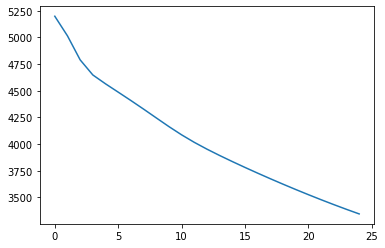

In [60]:
import matplotlib.pyplot as plt
plt.plot(w.epoch_loss)

In [61]:
w = Word2Vec([x for x in tokens if 'game' in x][:50], vector_size=6)

w.build_vocab(min_count=0)

# fit parameters
_ = w.train(window=3, epochs=150, learning_rate=0.01)

  0%|          | 0/150 [00:00<?, ?it/s]

In [62]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, token_to_id, id_to_token, k=20):
    idx = token_to_id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id_to_token[i], dists[i]) for i in ind]
    return out

sim_matrix = get_distance_matrix(w.model["W"], 'cosine')
for word in ['game', 'bat', 'play']:
    print(word, [t[1] for t in get_k_similar_words(word, sim_matrix, w.token_to_id, w.id_to_token)], "\n")

game ['days', 'coons', 'suicide', 'popular', 'true', 'baylor', 'beat', 'tigers', 'unlikely', 'straight', 'squeeze', 'dramatic', 'tonight', 'aaron', 'drawn-in', 'dinger', 'torre', 'determines', 'waving', 'read'] 

bat ['occured', 'problems', '5-2', '3-5', 'david', 'lankford', 'branson', '2', '3-2', 'fans', 'furthermore', 'catcher', 'candy', 'three', 'due', '4-3', 'good', 'even', 'hank', 'monday'] 

play ['star', 'six-hitter', 'stood', 'league', 'ekdfc', 'gerald', 'suicide', 'morning', 'two', 'expected', 'waving', 'hundley', '20', 'unlikely', '3', 'dramatic', '4th', '18-6', 'seaver', 'phils'] 



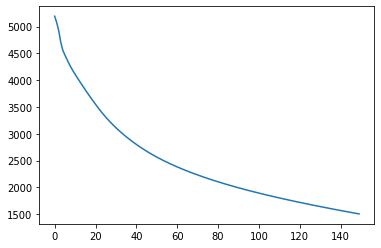

In [63]:
import matplotlib.pyplot as plt
plt.plot(w.epoch_loss)

In [64]:
w = Word2Vec([i for i in tokens if 'game' in i][:50], vector_size=10)

w.build_vocab(min_count=0)

# fit parameters
_ = w.train(window=3, epochs=50, learning_rate=0.03)

  0%|          | 0/50 [00:00<?, ?it/s]

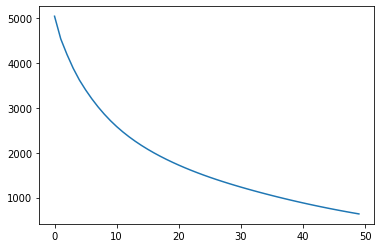

In [65]:
import matplotlib.pyplot as plt
plt.plot(w.epoch_loss)

In [66]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, token_to_id, id_to_token, k=20):
    idx = token_to_id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id_to_token[i], dists[i]) for i in ind]
    return out

sim_matrix = get_distance_matrix(w.model["W"], 'cosine')
for word in ['game', 'bat', 'play']:
    print(word, [t[1] for t in get_k_similar_words(word, sim_matrix, w.token_to_id, w.id_to_token)], "\n")

game ['defensive', 'whew', '12-13', 'calls', 'brewer', 'tying', '9/30', 'jays', 'determines', 'hill', 'tuesday', 'legitimately', "n't", 'games', 'would', 'vs.', 'maintain', 'marginal', 'league', 'belcher'] 

bat ['great', '19-8', 'nights', 'lineup', '9/29', 'joined', 'making', 'outshone', 'two', 'extremely', 'thompson', 'defensive', 'shortstops', 'jumped', 'defined', 'promote', 'coons', 'role', 'squeeze', 'meant'] 

play ['ken', 'entered', 'think', 'next', 'things', 'hoyt', 'including', 'let', 'occured', 'twin', 'best', 'hundley', '9/25', '2-9', 'defeated', 'three-run', 'time', '10/2', 'jays', 'track'] 



## Gensim

In [67]:
from gensim.models import Word2Vec

In [68]:
train = fetch_20newsgroups(data_home="/Users/flint/Data/sklearn/", subset='train', 
                           remove=('headers', 'footers', 'quotes'))

In [69]:
sentences = []
for doc in train.data:
    for s in nltk.tokenize.sent_tokenize(doc):
        sentences.append(s.lower())

In [70]:
tokens = [[x for x in word_tokenize(t) if x not in sw and x not in 
           string.punctuation] for t in sentences]

In [71]:
model = Word2Vec(sentences=tokens, vector_size=100, 
                 window=6, epochs=20, min_count=1, workers=4)

In [72]:
model.wv.similar_by_word('gun')

[('handgun', 0.7424942851066589),
 ('guns', 0.7384911179542542),
 ('hcikkk', 0.6669428944587708),
 ('unsurprisingly', 0.6582044363021851),
 ('control', 0.6468204259872437),
 ('crime', 0.6425794363021851),
 ('firearms', 0.6380162239074707),
 ('assault', 0.6378325819969177),
 ('owning', 0.637177586555481),
 ('handguns', 0.6165255308151245)]

In [73]:
model.wv.similarity('play', 'game')

0.6944172

### Base model and specialized models
Word embedding may be used also to get the specific shift of words among different corpora

#### Create a global model

In [ ]:
import copy

In [ ]:
politics = copy.deepcopy(model)
religion = copy.deepcopy(model)

In [ ]:
politics_docs = []
religion_docs = []
for i, text in enumerate(train.data):
    class_label = train.target_names[train.target[i]]
    if class_label in ['talk.politics.misc', 'talk.religion.misc']:
        for sentence in nltk.tokenize.sent_tokenize(text):
            tokens = [x for x in word_tokenize(sentence) if x not in sw and x not in string.punctuation]
            if class_label == 'talk.politics.misc':
                politics_docs.append(tokens)
            else:
                religion_docs.append(tokens)

#### Update the model for specific corpora to obtain specific fine-tuned models

In [ ]:
politics.train(politics_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
religion.train(religion_docs, total_examples=model.corpus_count, epochs=model.epochs)

#### Compare the models

In [ ]:
politics.wv.most_similar('gun')

In [ ]:
religion.wv.most_similar('gun')

In [ ]:
religion.wv.similarity('church', 'person')

In [ ]:
politics.wv.similarity('church', 'person')

## Pre-trained models

In [74]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

In [75]:
wv = KeyedVectors.load_word2vec_format(datapath("/Users/flint/Data/word2vec/GoogleNews-vectors-negative300.bin"), 
                                       binary=True)

In [76]:
wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

In [78]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


In [79]:
for x, y in wv.most_similar('car'):
    print(x, y)

vehicle 0.7821096181869507
cars 0.7423831224441528
SUV 0.7160962224006653
minivan 0.6907036900520325
truck 0.6735789775848389
Car 0.6677608489990234
Ford_Focus 0.667320191860199
Honda_Civic 0.6626849174499512
Jeep 0.651133120059967
pickup_truck 0.6441438794136047


In [80]:
vectors = []
for word in ['car', 'minivan', 'bicycle', 'airplane']:
    vectors.append(wv.get_vector(word))
V = np.array(vectors)

In [83]:
v = V.mean(axis=0)
#v = v - wv.get_vector('car')

In [84]:
wv.similar_by_vector(v)

[('car', 0.852258026599884),
 ('minivan', 0.8156529664993286),
 ('vehicle', 0.7754934430122375),
 ('SUV', 0.7660486698150635),
 ('bicycle', 0.7264742255210876),
 ('pickup_truck', 0.723552942276001),
 ('scooter', 0.7198848724365234),
 ('truck', 0.7041884064674377),
 ('Jeep', 0.7000145316123962),
 ('motorcycle', 0.6802986264228821)]

### Analogy and compositionality

FRANCE : PARIS = ITALY : ?

PARIS - FRANCE + ITALY

In [77]:
wv.most_similar(positive=['Paris', 'Italy'], negative=['France'])

[('Milan', 0.7222141623497009),
 ('Rome', 0.702830970287323),
 ('Palermo_Sicily', 0.5967570543289185),
 ('Italian', 0.5911272764205933),
 ('Tuscany', 0.5632812976837158),
 ('Bologna', 0.5608358383178711),
 ('Sicily', 0.5596384406089783),
 ('Bologna_Italy', 0.5470058917999268),
 ('Berna_Milan', 0.5464027523994446),
 ('Genoa', 0.5308900475502014)]

In [85]:
wv.doesnt_match("school professor apple student".split())

'apple'

In [86]:
vp = wv['school']
vr = wv['professor']
vx = wv['student']
m = (vp + vr + vx) / 3

In [87]:
wv.similar_by_vector(m)

[('student', 0.8481254577636719),
 ('professor', 0.7627506852149963),
 ('teacher', 0.6942789554595947),
 ('school', 0.6849855780601501),
 ('students', 0.6768636703491211),
 ('lecturer', 0.6700003147125244),
 ('faculty', 0.645453155040741),
 ('university', 0.6376535892486572),
 ('professors', 0.6346085667610168),
 ('associate_professor', 0.6325882077217102)]

In [ ]:
pairs = [
    ('lecturer', 'school'),
    ('lecturer', 'professor'),
    ('lecturer', 'student'),
    ('lecturer', 'teacher'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

In [ ]:
wv.most_similar('buy')

In [ ]:
wv.similarity('buy', 'money')